<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering-and-Model-evaluation-+-validation" data-toc-modified-id="Feature-Engineering-and-Model-evaluation-+-validation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering and Model evaluation + validation</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Features-importance" data-toc-modified-id="Features-importance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Features importance</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#information-gain" data-toc-modified-id="information-gain-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>information gain</a></span></li><li><span><a href="#Features-creation" data-toc-modified-id="Features-creation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Features creation</a></span></li><li><span><a href="#Remove-outliers" data-toc-modified-id="Remove-outliers-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Remove outliers</a></span></li><li><span><a href="#Recursive-feature-elimination" data-toc-modified-id="Recursive-feature-elimination-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Recursive feature elimination</a></span></li></ul></div>

# Feature Engineering and Model evaluation + validation

Let's work on the dataset we've been using during the model evaluation and evaluation notebook

In [25]:
# Headers 
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import copy
from collections import Counter
from dataset import Dataset as dataset
from gplearn.genetic import SymbolicTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss
from math import log2
from scipy import stats
from scipy.stats import kruskal
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm_notebook
from typing import List


# This line is important if you want your results to be reproducible
np.random.seed(555)

In [26]:
def do_discretize(df):
    df.discretize('x0', [(15, 20), (20, 25), (25, 30),
                         (30, 35), (35, 40), (40, 50)])
    df.discretize('x3', [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 20)])
    df.drop_na()
    return df
    
def do_onehot(df):
    df.onehot_encode(df.names('features'))
    return df

def init_dataset(onehot=True, discretize=True):
    URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data'
    df = dataset(URL, header=None)
    df.to_int()
    df.drop_na()
    df.set_target('x9')
    df.to_numerical(df.categorical_features)

    # Binomize and categorical
    df.drop_samples(df.samples_matching(3))
    df = df.to_categorical(['x1', 'x2', 'x4', 'x5', 'x6', 'x7', 'x8'])
    
    if discretize is True:
        do_discretize(df)

    if onehot is True:
        do_onehot(df)

    return df

In [27]:
class validate:
    
    train_f1 = []
    test_f1 = []
    
    def this(self, df, keep=True, silent=False, plot=False):
        test_f1 = []
        for i in range(10):
            X, y = df.split(seed=i*23)
            baseline_F1, F1_scores, F1_std = self.evaluate_cv(X.train, y.train)
            test_f1.append(self.evaluate(X.train, y.train, X.test, y.test))
        test_F1 = np.median(test_f1)
        
        if silent == False:
            print('CV Training F1: {:.4f}'.format(baseline_F1))
            print('Test F1: {:.4f}'.format(test_F1))

        if keep is True:
            self.train_f1.append(baseline_F1)
            self.test_f1.append(test_F1)
            
        if plot is True:
            self.plot()
        
        return baseline_F1, test_F1
    
    def plot(self):
        num_items = len(self.train_f1)
        plt.figure(figsize=(8,6))
        plt.plot(range(num_items), self.train_f1, marker='.', label='F1 training')
        plt.plot(range(num_items), self.test_f1, marker='.', label='F1 test')
        plt.xticks(range(num_items), range(num_items))
        plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, X_train, y_train, X_test, y_test):
        my_model = LogisticRegression().fit(X_train, y_train)
        y_hat = my_model.predict(X_test)
        F1 = f1_score(y_test, y_hat)
        return F1


    def evaluate_cv(self, X_train, y_train):
        my_model = LogisticRegression()
        cv_scores = cross_val_score(
            my_model, X_train, y_train, scoring='f1', cv=20)
        med = np.median(cv_scores)
        std = np.std(cv_scores)

        return med, cv_scores, std
    
validate = validate()

# Baseline

In [28]:
df = init_dataset(onehot=False, discretize=False)
df = df.to_numerical(df.categorical_features)
print('Baseline\n--------')
baseline_F1, test_F1 = validate.this(df)

Baseline
--------
CV Training F1: 0.8000
Test F1: 0.7902


# Features importance

In [29]:
f_f1 = []
t_f1 = []
best = {}

for num in tqdm_notebook(range(1, len(df.names()))):
    df2 = df.all.copy(deep=True)
    df2 = dataset.from_dataframe(df2)
    df2.set_target('x9')

    top_features = df2.features_importance(num_features=num)
    df2.keep_columns(list(top_features.keys()))
    best[num] = list(top_features.keys())

    filtered_F1, filtered_test_F1 = validate.this(df2, keep=False, silent=True)
    f_f1.append(filtered_F1)
    t_f1.append(filtered_test_F1)

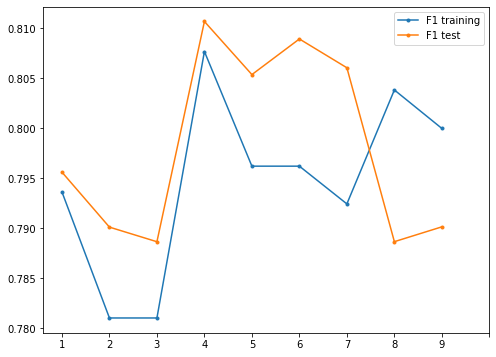

In [30]:
plt.figure(figsize=(8,6))
plt.plot(range(len(f_f1)), f_f1, marker='.', label='F1 training')
plt.plot(range(len(t_f1)), t_f1, marker='.', label='F1 test')
plt.xticks(range(0, len(df.names())), range(1, len(df.names())))
plt.legend(loc='best')
plt.show()

CV Training F1: 0.8077
Test F1: 0.8107


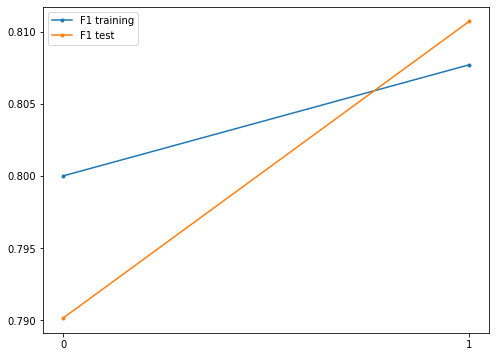

(0.8076923076923077, 0.810695797139598)

In [31]:
df.keep_columns(best[4])
validate.this(df, plot=True)

# EDA

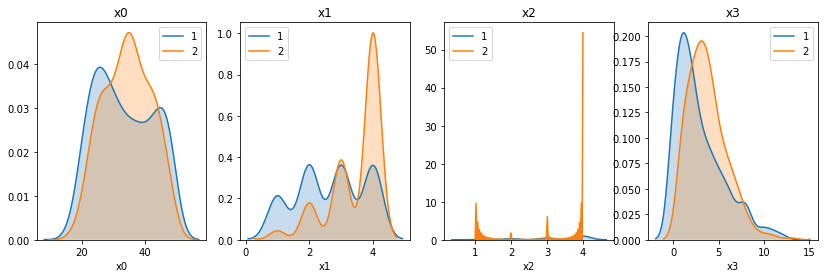

In [32]:
plt.figure(figsize=(14, 4))
num_plots = len(list(df.numerical))
for index, feature in enumerate(list(df.numerical)):
    plt.subplot(1, num_plots, index+1)
    df.plot_double_density(feature)
    plt.legend(loc='best'); plt.ylabel('');
    plt.title(feature)
plt.show();

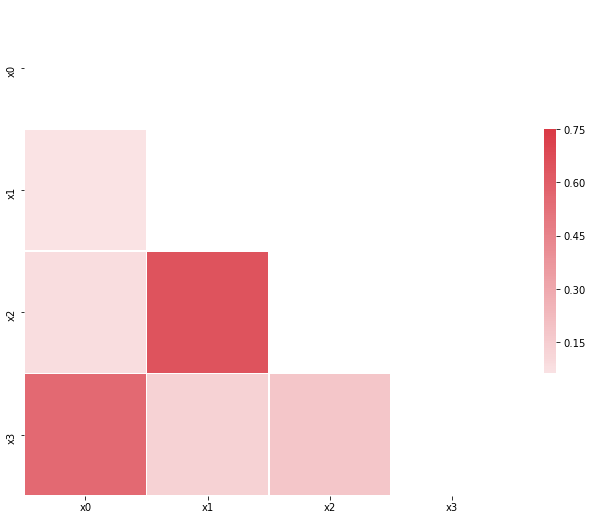

,x0,x1,x2,x3
x0,1.000000,0.062871,0.089042,0.560807
x1,0.062871,1.000000,0.644114,0.134934
x2,0.089042,0.644114,1.000000,0.183079
x3,0.560807,0.134934,0.183079,1.000000


In [33]:
df.plot_correlation_matrix(df.numerical_correlated()[1])
df.numerical_correlated()[1]

# information gain

In [34]:
# ig = [df.IG(vble) for vble in df.categorical_features]
# 
# plt.plot(range(len(df.categorical_features)), ig, marker='.')
# plt.xticks(range(len(df.categorical_features)), df.categorical_features)
# plt.show()

In [35]:
# df = df.drop_columns(['x4', 'x5'])
# assess(do_onehot(do_discretize(copy(df))))

# Features creation

In [36]:
X, y = df.split()
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
gp = SymbolicTransformer(generations=25, population_size=1000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005, max_samples=0.9, 
                         verbose=1, random_state=0, n_jobs=3)

gp.fit(pd.get_dummies(df.features), df.target);
gp_features = gp.transform(df.data.values)
# gp_features = gp.transform(pd.get_dummies(df.features))

# Move the new features at the end of the existing dataframe
df_ext = pd.DataFrame(gp_features)
df_ext.columns = ['gp{}'.format(i) for i in range(len(list(df_ext)))]
df.add_columns(df_ext)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.40         0.164182        9         0.459491         0.436311     17.13s
   1    13.95         0.304483       39         0.495474         0.299764     25.10s
   2    12.46         0.366867       26         0.510346         0.262355     28.53s
   3    15.03         0.415802        6         0.514764         0.295485     26.34s
   4    12.13         0.424554       21         0.517045         0.286453     28.19s
   5    11.20         0.439259       19         0.526493         0.336653     27.84s
   6    11.12         0.447468       23         0.517288         0.300446     23.45s
   7    11.02         0.454735       11         0.523003          0.23992     23.48s
   8    10.09         0.454548       16         0.524813         0.332469  

CV Training F1: 0.7962
Test F1: 0.8040


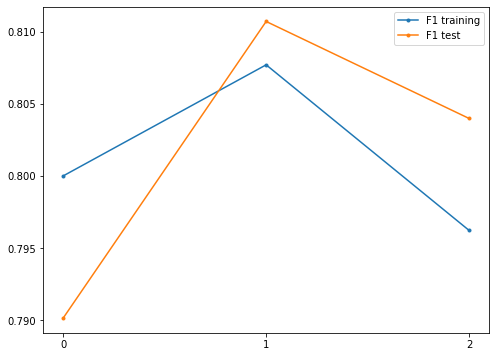

(0.7962264150943397, 0.8039792439738136)

In [37]:
# Validate result
validate.this(df, plot=True)

In [38]:
df.all.head()

,x0,x1,x2,x3,gp0,gp1,gp2,gp3,gp4,gp5,gp6,gp7,gp8,gp9,x9
0,24,2,3,3,2.828427,5.656854,16.0,6.928203,8.0,4.0,3.363586,3.363586,6.727171,11.313708,1
1,45,1,3,10,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1
2,43,2,3,7,2.828427,5.656854,16.0,9.513657,8.0,4.0,3.363586,3.363586,6.727171,11.313708,1
3,42,3,2,9,5.196152,15.588457,81.0,27.000000,27.0,9.0,6.838521,6.838521,20.515564,46.765372,1
4,36,3,3,8,5.196152,15.588457,81.0,25.455844,27.0,9.0,6.838521,6.838521,20.515564,46.765372,1


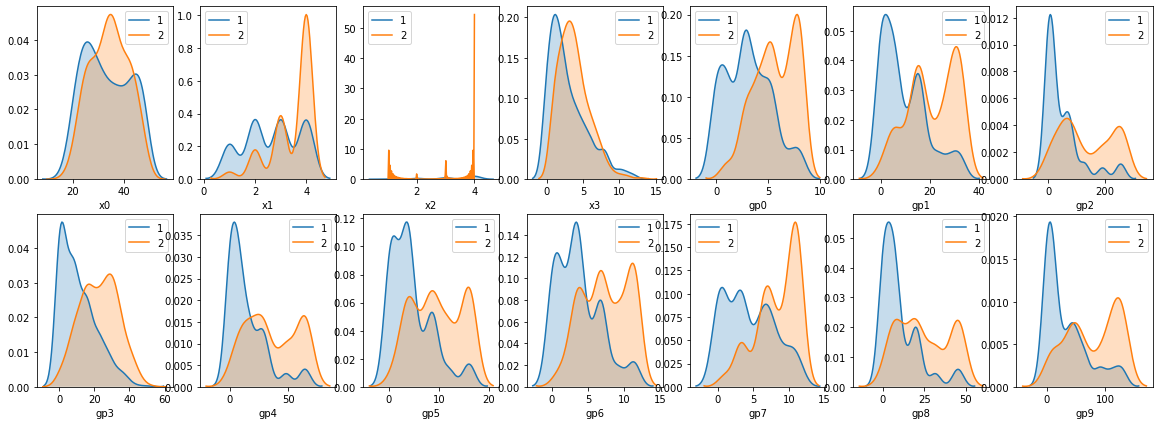

In [39]:
plt.figure(figsize=(20, 7))
num_plots = len(list(df.numerical))
for index, feature in enumerate(list(df.numerical)[:7]):
    plt.subplot(2, 7, index+1)
    df.plot_double_density(feature)
for index, feature in enumerate(list(df.numerical)[7:]):
    plt.subplot(2, 7, index+1+7)
    df.plot_double_density(feature)

plt.show();

Removing any of the features that look pretty similar result in lower F1.

# Remove outliers

CV Training F1: 0.8235
Test F1: 0.8107


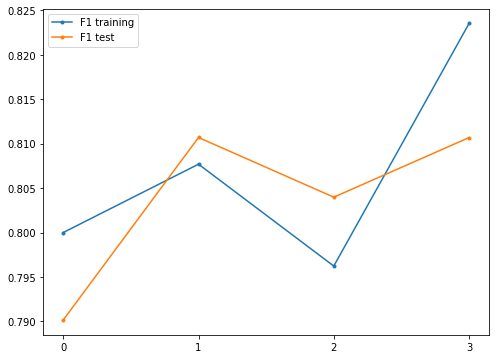

(0.8235294117647058, 0.8106857810990797)

In [40]:
df.drop_samples(df.outliers())
validate.this(df, plot=True)

# Recursive feature elimination

In [41]:
def rfe(ds, num_features):
    estimator = LogisticRegression(random_state=123)
    selector = RFE(estimator, num_features, step=1)
    selector = selector.fit(pd.get_dummies(df.features), df.target)
    return selector.support_

df_dummified = pd.get_dummies(df.features)
tst_scores_rfe = []
min_range = 3
max_range = 14
for num_features in tqdm_notebook(range(min_range, max_range)):
    best_features = rfe(df, num_features)
    X = df_dummified[df_dummified.columns[best_features]]
    hdf = dataset.from_dataframe(pd.concat([X, df.target], axis=1))
    hdf.set_target('x9')
    res, _ = validate.this(hdf, keep=False, silent=True)
    tst_scores_rfe.append(res)
    del(hdf)
    del(X)

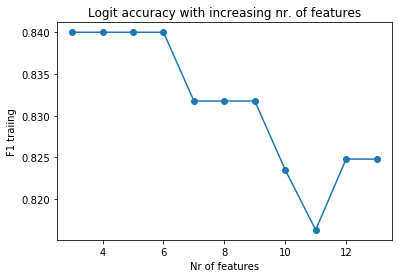

In [42]:
plt.plot(range(min_range, max_range), tst_scores_rfe, 'o-')
plt.title('Logit accuracy with increasing nr. of features')
plt.ylabel('F1 traiing')
plt.xlabel('Nr of features')
plt.show();

CV Training F1: 0.8400
Test F1: 0.8171


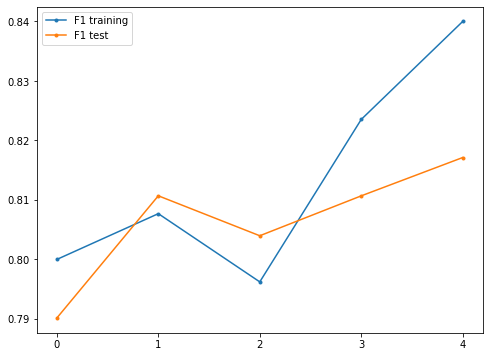

(0.8400000000000001, 0.8171271052950442)


In [43]:
df_dummified = pd.get_dummies(df.features)
best_features = rfe(df, 6)
df_dummified = df_dummified[df_dummified.columns[best_features]]
ddf = dataset.from_dataframe(pd.concat([df_dummified, df.target], axis=1))
ddf.set_target('x9')
print(validate.this(ddf, plot=True))